In [1]:
import torch
import time
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import numpy as np

In [2]:
from utils import Logger

In [3]:
def mnist_data():
    compose = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
    output_dir = './dataset'
    return datasets.MNIST(root=output_dir, train=True, transform=compose, download=True)

In [4]:
data = mnist_data()

In [5]:
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

In [6]:
num_batches = len(data_loader)

## Define Classes

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
class DiscriminatorNet(torch.nn.Module):
    """
    A discriminative neural network.
    """
    def __init__(self, hidden_layer_sizes):
        super().__init__()
        n_features = 784
        n_out = 1

        self._hidden_layers = []
        for i, lsize in enumerate(hidden_layer_sizes):
            self._hidden_layers.append(nn.Sequential(
                nn.Linear(n_features if i == 0 else hidden_layer_sizes[i - 1], hidden_layer_sizes[i]).to(device),
                nn.LeakyReLU(0.2).to(device),
                nn.Dropout(0.3).to(device)
            ).to(device))
        self._out = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], n_out).to(device),
            nn.Sigmoid().to(device)
        ).to(device)
        
    def forward(self, x):
        cur = x
        for layer in self._hidden_layers:
            cur = layer(cur)
        return self._out(cur)

In [9]:
class GeneratorNet(torch.nn.Module):
    """
    A generator network.
    """
    def __init__(self, n_features, hidden_layer_sizes):
        super().__init__()
        self._n_features = n_features
        n_out = 784

        self._hidden_layers = []
        for i, lsize in enumerate(hidden_layer_sizes):
            self._hidden_layers.append(nn.Sequential(
                nn.Linear(n_features if i == 0 else hidden_layer_sizes[i - 1], hidden_layer_sizes[i]).to(device),
                nn.LeakyReLU(0.2).to(device),
            ).to(device))
        self._out = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], n_out).to(device),
            nn.Tanh().to(device)
        ).to(device)
    
    def forward(self, x):
        cur = x
        for layer in self._hidden_layers:
            cur = layer(cur)
        return self._out(cur)

In [10]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

In [11]:
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [12]:
def noise(size, noise_vec_size):
    return Variable(torch.randn(size, noise_vec_size)).to(device)

In [13]:
def ones_target(size):
    return Variable(torch.ones(size, 1)).to(device)

In [14]:
def zeros_target(size):
    return Variable(torch.zeros(size, 1)).to(device)

## Create Generator and Discriminator

In [15]:
noise_vec_size = 100

In [16]:
discriminator = DiscriminatorNet((1024, 512, 256)).to(device)

In [17]:
generator = GeneratorNet(100, (256, 512, 1024)).to(device)

In [18]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

In [19]:
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [20]:
loss = nn.BCELoss().to(device)

In [21]:
def train_discriminator(optimizer, real_data, fake_data):
    batch_size = real_data.size(0)
    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(batch_size))
    error_real.backward()
    
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(batch_size))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

In [22]:
def train_generator(optimizer, fake_data):
    batch_size = fake_data.size(0)
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, ones_target(batch_size))
    error.backward()
    optimizer.step()
    return error

In [23]:
num_test_samples = 16
test_noise = noise(num_test_samples, noise_vec_size)

## Training

In [24]:
def train(num_epochs):
    start = time.time()
    logger = Logger(model_name='VGAN', data_name='MNIST')
    for epoch in range(num_epochs):
        epoch_visualized = False
        for idx, (real_batch, _) in enumerate(data_loader):
            batch_size = real_batch.size(0)
            
            real_data = Variable(images_to_vectors(real_batch)).to(device)
            fake_data = generator(noise(batch_size, noise_vec_size)).detach()
            
            d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)
            
            fake_data = generator(noise(batch_size, noise_vec_size))
            
            g_error = train_generator(g_optimizer, fake_data)
            
            logger.log(d_error, g_error, epoch, idx, num_batches)
            
            if epoch % (num_epochs // 20) == 0 and not epoch_visualized:
                test_images = vectors_to_images(generator(test_noise))
                test_images = test_images.data
                
                logger.log_images(
                    test_images.cpu(), num_test_samples,
                    epoch, idx, num_batches
                )
                logger.display_status(
                    epoch, num_epochs, idx, num_batches,
                    d_error, g_error, d_pred_real, d_pred_fake
                )
                epoch_visualized = True
    end = time.time()
    print('Training finished in {0:.2f}s.'.format(end - start))

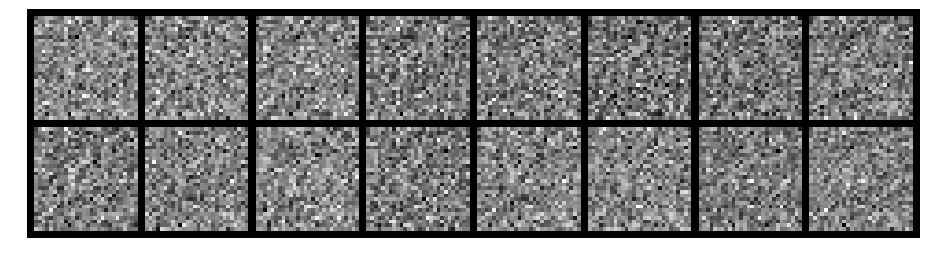

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3880, Generator Loss: 0.7098
D(x): 0.4916, D(G(z)): 0.4921


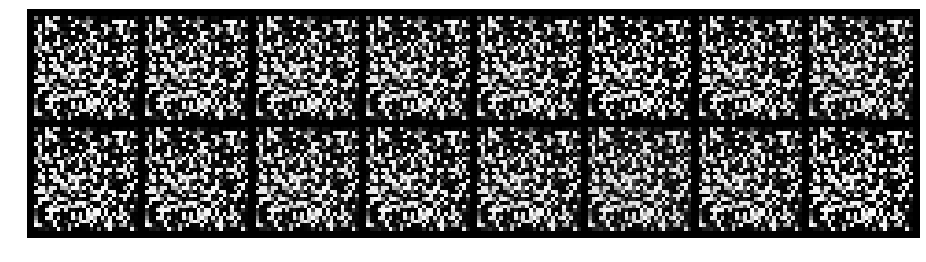

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 1.3979, Generator Loss: 0.6806
D(x): 0.5011, D(G(z)): 0.5063


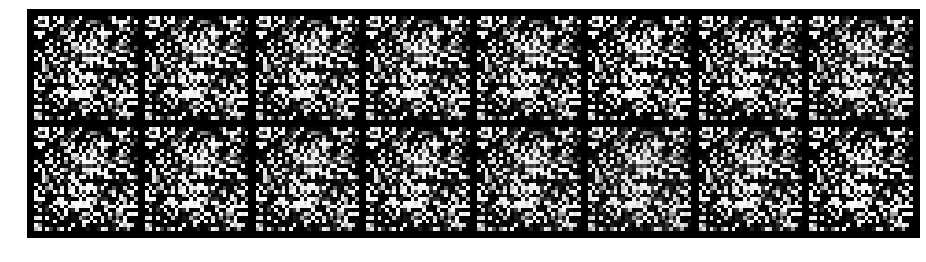

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 1.4013, Generator Loss: 0.7000
D(x): 0.4910, D(G(z)): 0.4979


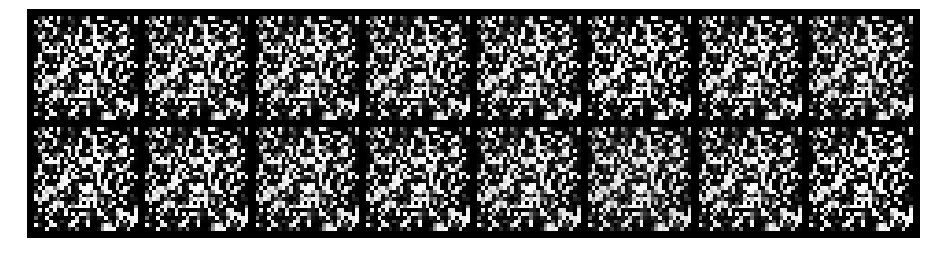

Epoch: [30/200], Batch Num: [0/600]
Discriminator Loss: 1.3877, Generator Loss: 0.6908
D(x): 0.5009, D(G(z)): 0.5012


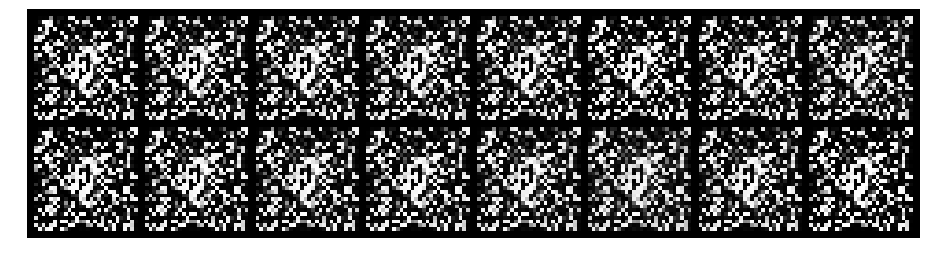

Epoch: [40/200], Batch Num: [0/600]
Discriminator Loss: 1.4316, Generator Loss: 0.6739
D(x): 0.4917, D(G(z)): 0.5134


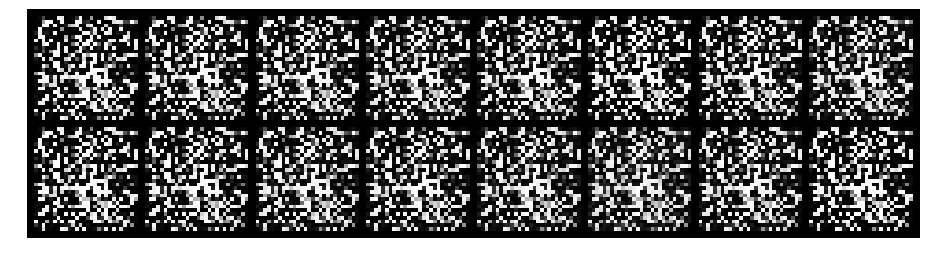

Epoch: [50/200], Batch Num: [0/600]
Discriminator Loss: 1.3879, Generator Loss: 0.7036
D(x): 0.4933, D(G(z)): 0.4937


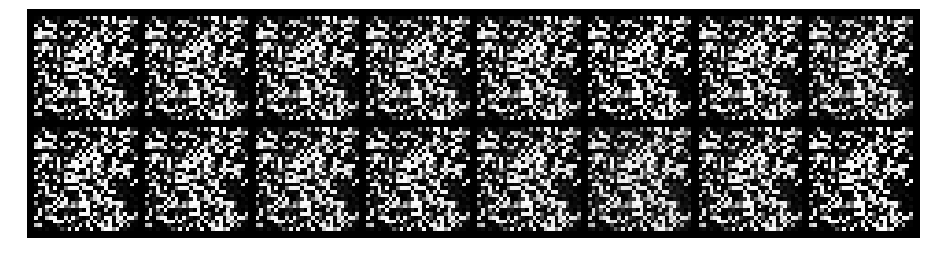

Epoch: [60/200], Batch Num: [0/600]
Discriminator Loss: 1.3734, Generator Loss: 0.6929
D(x): 0.5080, D(G(z)): 0.5009


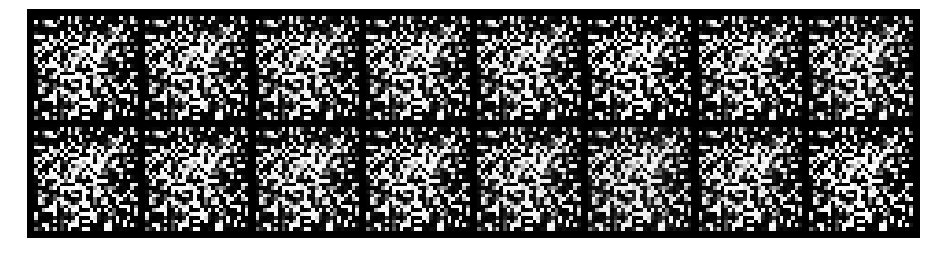

Epoch: [70/200], Batch Num: [0/600]
Discriminator Loss: 1.4041, Generator Loss: 0.7031
D(x): 0.4885, D(G(z)): 0.4966


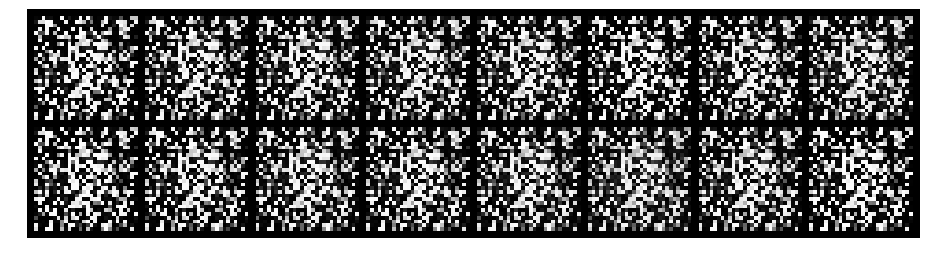

Epoch: [80/200], Batch Num: [0/600]
Discriminator Loss: 1.3686, Generator Loss: 0.6972
D(x): 0.5079, D(G(z)): 0.4983


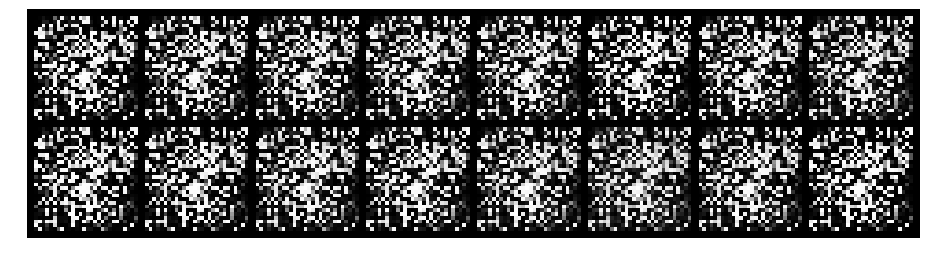

Epoch: [90/200], Batch Num: [0/600]
Discriminator Loss: 1.4046, Generator Loss: 0.6875
D(x): 0.4937, D(G(z)): 0.5024


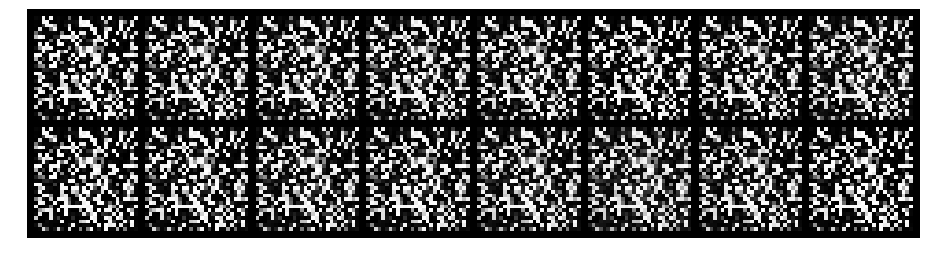

Epoch: [100/200], Batch Num: [0/600]
Discriminator Loss: 1.3979, Generator Loss: 0.7108
D(x): 0.4896, D(G(z)): 0.4946


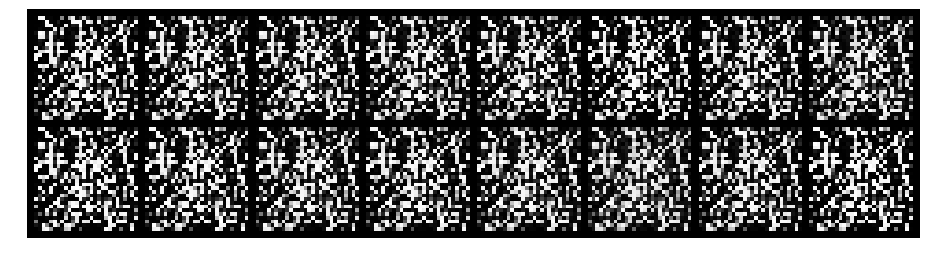

Epoch: [110/200], Batch Num: [0/600]
Discriminator Loss: 1.4093, Generator Loss: 0.6877
D(x): 0.4921, D(G(z)): 0.5030


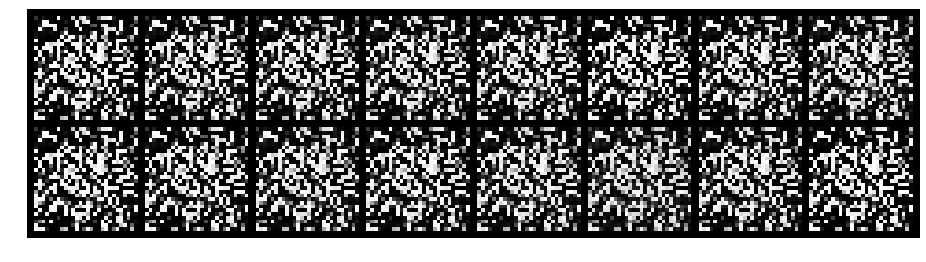

Epoch: [120/200], Batch Num: [0/600]
Discriminator Loss: 1.3916, Generator Loss: 0.6782
D(x): 0.5104, D(G(z)): 0.5123


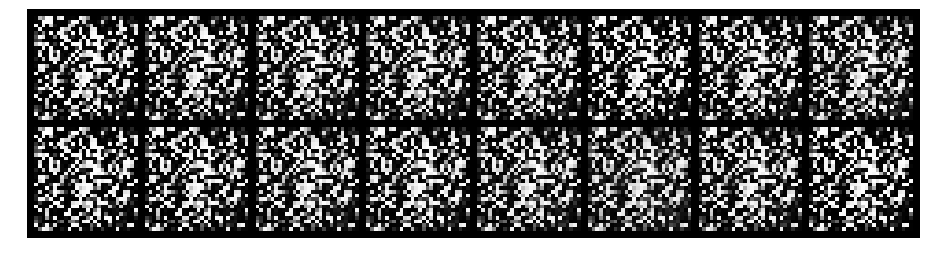

Epoch: [130/200], Batch Num: [0/600]
Discriminator Loss: 1.3984, Generator Loss: 0.6792
D(x): 0.5031, D(G(z)): 0.5086


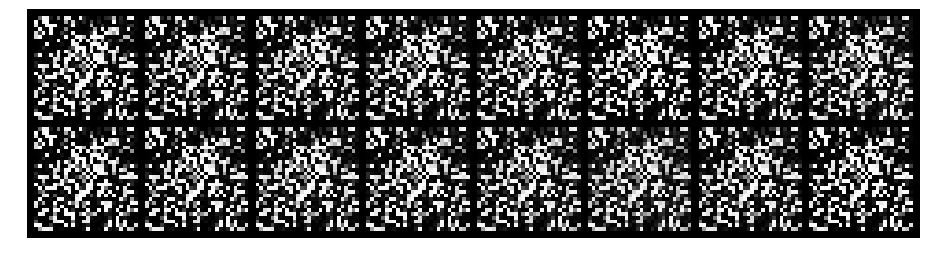

Epoch: [140/200], Batch Num: [0/600]
Discriminator Loss: 1.4095, Generator Loss: 0.6874
D(x): 0.4927, D(G(z)): 0.5038


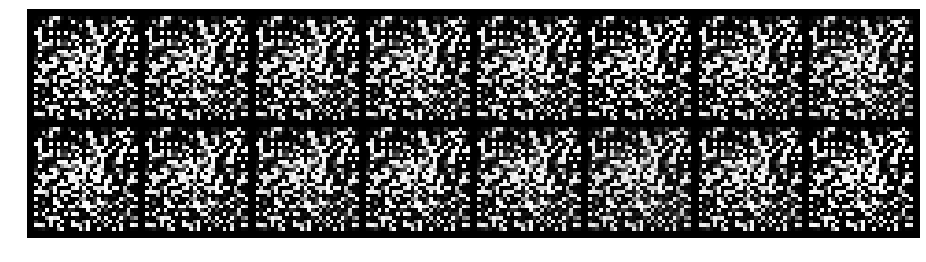

Epoch: [150/200], Batch Num: [0/600]
Discriminator Loss: 1.3780, Generator Loss: 0.7026
D(x): 0.5025, D(G(z)): 0.4977


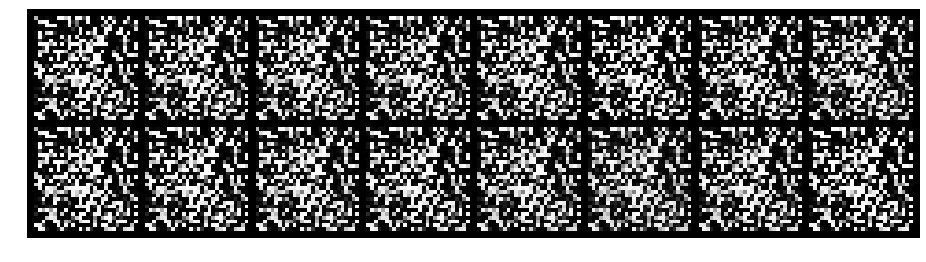

Epoch: [160/200], Batch Num: [0/600]
Discriminator Loss: 1.4269, Generator Loss: 0.6756
D(x): 0.4882, D(G(z)): 0.5076


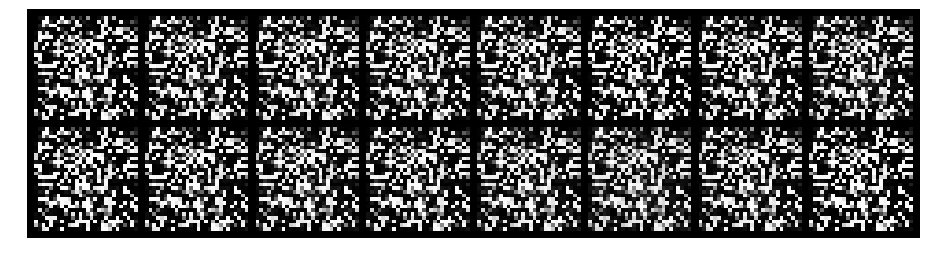

Epoch: [170/200], Batch Num: [0/600]
Discriminator Loss: 1.3921, Generator Loss: 0.6898
D(x): 0.5016, D(G(z)): 0.5039


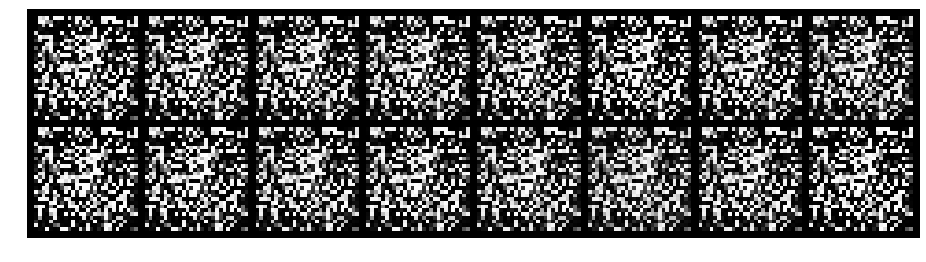

Epoch: [180/200], Batch Num: [0/600]
Discriminator Loss: 1.3837, Generator Loss: 0.6946
D(x): 0.5052, D(G(z)): 0.5034


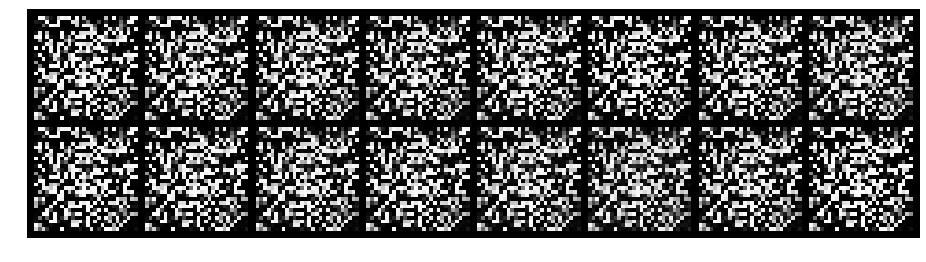

Epoch: [190/200], Batch Num: [0/600]
Discriminator Loss: 1.3838, Generator Loss: 0.6806
D(x): 0.5089, D(G(z)): 0.5069
Training finished in 3130.93s.


In [25]:
train(200)